In [111]:
%load_ext autoreload
from ddls.plotting.plotting import plot_line, plot_bar, plot_hist

from collections import defaultdict
from sqlitedict import SqliteDict
import pprint
import glob
import time
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt

from IPython.display import display

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [170]:
# load files
base_folder = '/scratch/datasets/ddls/sims/'
base_name = 'job_placing'

# ids = [108]
ids = [108, 116]

In [171]:
results = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
for i in ids:
    agent = base_name + f'_{i}'
    paths = [reset_folder for reset_folder in glob.glob(base_folder + f'{base_name}/{agent}/*.sqlite')]
    print(f'\ni: {i} | agent: {agent} | paths: {paths}')
    
    for path in paths:
        start_time = time.time()
        file = path.split('/')[-1].split('.')[0]
        with SqliteDict(path) as log:
            for key, val in log.items():
                results[file][agent][key].extend(val)
            log.close()
        print(f'Loaded {path} in {time.time() - start_time:.3f} s.')


i: 108 | agent: job_placing_108 | paths: ['/scratch/datasets/ddls/sims/job_placing/job_placing_108/rllib_results.sqlite', '/scratch/datasets/ddls/sims/job_placing/job_placing_108/launcher_stats.sqlite']
Loaded /scratch/datasets/ddls/sims/job_placing/job_placing_108/rllib_results.sqlite in 0.393 s.
Loaded /scratch/datasets/ddls/sims/job_placing/job_placing_108/launcher_stats.sqlite in 0.124 s.

i: 116 | agent: job_placing_116 | paths: ['/scratch/datasets/ddls/sims/job_placing/job_placing_116/rllib_results.sqlite', '/scratch/datasets/ddls/sims/job_placing/job_placing_116/launcher_stats.sqlite']
Loaded /scratch/datasets/ddls/sims/job_placing/job_placing_116/rllib_results.sqlite in 0.121 s.
Loaded /scratch/datasets/ddls/sims/job_placing/job_placing_116/launcher_stats.sqlite in 0.147 s.


In [172]:
print(results.keys())
print('')
print(results)

dict_keys(['rllib_results', 'launcher_stats'])

defaultdict(<function <lambda> at 0x7f4b4ce20820>, {'rllib_results': defaultdict(<function <lambda>.<locals>.<lambda> at 0x7f4b4e637d30>, {'job_placing_108': defaultdict(<class 'list'>, {'trial_id': ['default'], 'experiment_id': ['9213f2b1b8c24fb6acc799d379c9dc31'], 'pid': [2875772], 'hostname': ['mammoth.ee.ucl.ac.uk'], 'node_ip': ['128.40.41.23'], 'config': [{'num_workers': 32, 'num_envs_per_worker': 1, 'create_env_on_driver': False, 'rollout_fragment_length': 1, 'batch_mode': 'complete_episodes', 'gamma': 0.99, 'lr': 5e-05, 'train_batch_size': 32, 'model': {'_use_default_native_models': False, '_disable_preprocessor_api': False, 'fcnet_hiddens': [8], 'fcnet_activation': 'relu', 'conv_filters': None, 'conv_activation': 'relu', 'post_fcnet_hiddens': [], 'post_fcnet_activation': 'relu', 'free_log_std': False, 'no_final_linear': False, 'vf_share_layers': False, 'use_lstm': False, 'max_seq_len': 20, 'lstm_cell_size': 256, 'lstm_use_prev_act

,Epoch,Agent,episode_reward_min,episode_reward_mean,normalised_episode_reward_mean,episode_reward_max
0,1,job_placing_108,-4.573115,-4.451642,0.468750,-4.313973
1,2,job_placing_108,-4.573115,-4.451642,0.468750,-4.313973
2,3,job_placing_108,-4.573115,-4.457041,0.447917,-4.313973
3,4,job_placing_108,-4.573115,-4.443544,0.500000,-4.313973
4,5,job_placing_108,-4.573115,-4.448727,0.480000,-4.313973
...,...,...,...,...,...,...
191,22,job_placing_116,-4.573115,-4.425875,0.568182,-4.313973
192,23,job_placing_116,-4.573115,-4.426643,0.565217,-4.313973
193,24,job_placing_116,-4.573115,-4.427348,0.562500,-4.313973
194,25,job_placing_116,-4.573115,-4.427995,0.560000,-4.313973


Plotting episode_reward_min vs. Epoch...
Plotted episode_reward_min vs. Epoch in 0.040 s.


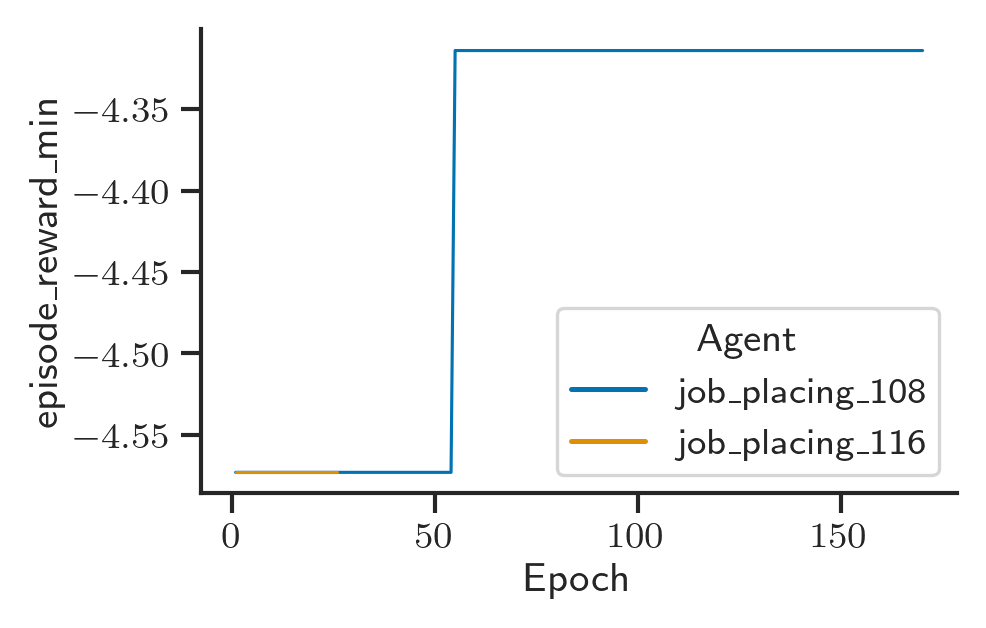

Plotting episode_reward_mean vs. Epoch...
Plotted episode_reward_mean vs. Epoch in 0.035 s.


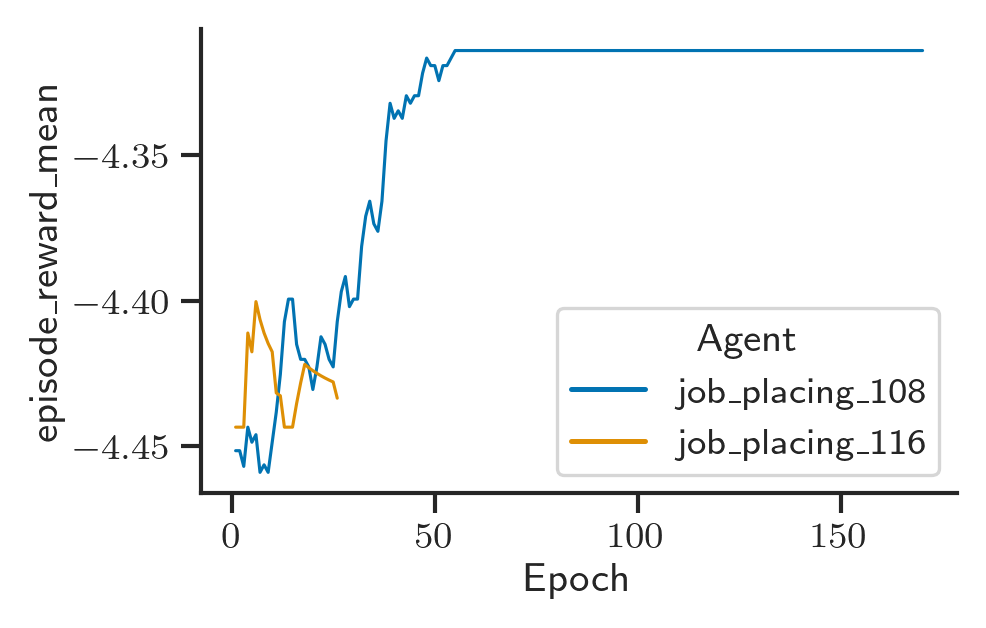

Plotting normalised_episode_reward_mean vs. Epoch...
Plotted normalised_episode_reward_mean vs. Epoch in 0.035 s.


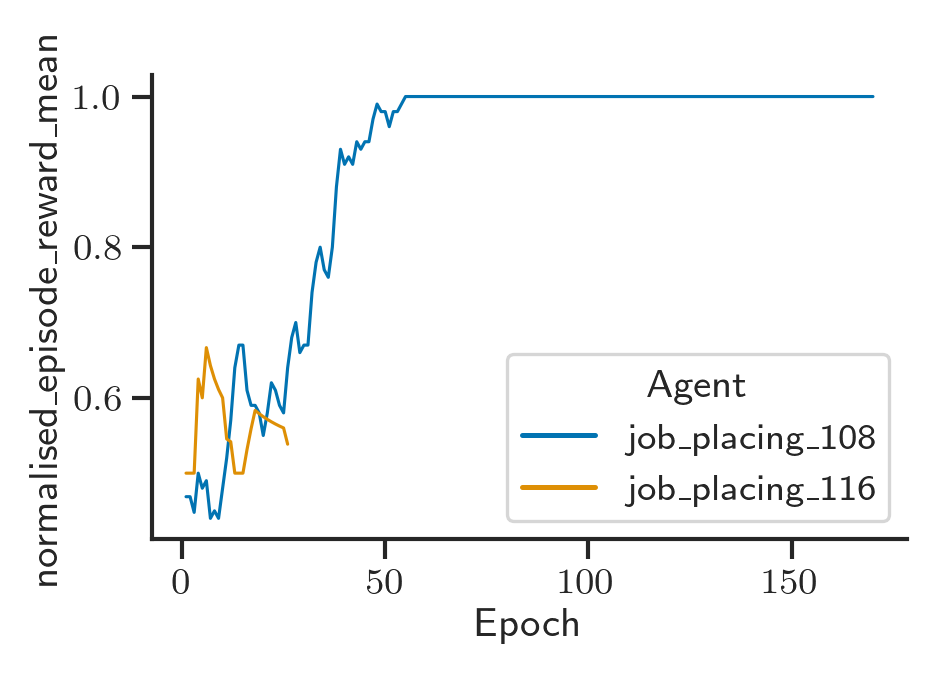

Plotting episode_reward_max vs. Epoch...
Plotted episode_reward_max vs. Epoch in 0.037 s.


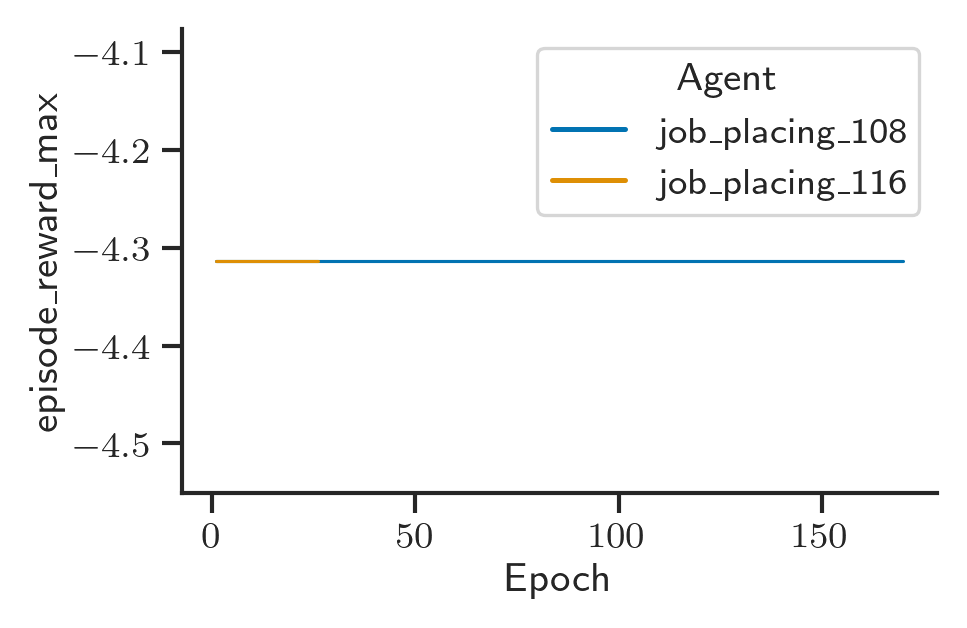

In [175]:
# RLLIB EPOCH ACTOR STATS
metrics_to_plot = {'episode_reward_mean', 'episode_reward_max', 'episode_reward_min', 'normalised_episode_reward_mean'}
epochs_stats = defaultdict(lambda: [])
if 'rllib_results' in results:
    for agent, training_stats in results['rllib_results'].items():
        epochs_stats['Epoch'].extend(training_stats['training_iteration'])
        epochs_stats['Agent'].extend([agent for _ in range(len(training_stats['training_iteration']))])
        for metric in metrics_to_plot:
            if metric not in {'normalised_episode_reward_mean'}:
                epochs_stats[metric].extend(training_stats[metric])
        
        if 'normalised_episode_reward_mean' in metrics_to_plot:
            max_reward = np.amax(training_stats['episode_reward_max'])
            min_reward = np.amin(training_stats['episode_reward_min'])
            epochs_stats['normalised_episode_reward_mean'].extend([(abs(mean_reward - min_reward) / (abs(max_reward - min_reward))) for mean_reward in training_stats['episode_reward_mean']])
            
epochs_stats_df = pd.DataFrame(epochs_stats)
display(epochs_stats_df)

scaling_factor = 1
x = 'Epoch'
hue = 'Agent'
for metric in metrics_to_plot:
    print(f'Plotting {metric} vs. {x}...')
    start_time = time.time()
    fig = plot_line(epochs_stats_df, 
                    x=x, 
                    y=metric, 
                    hue=hue, 
                    xlabel=x, 
                    ylabel=metric, 
                    err_style='band', # 'band' 'bars'
                    ci=68, # 95 68
                    scaling_factor=scaling_factor,
                    show_fig=False)
    print(f'Plotted {metric} vs. {x} in {time.time() - start_time:.3f} s.')
    plt.show()

,episode_reward,episode_lengths,Agent,Epoch
0,-4.573115,1,job_placing_108,1
1,-4.313973,1,job_placing_108,1
2,-4.313973,1,job_placing_108,1
3,-4.573115,1,job_placing_108,1
4,-4.573115,1,job_placing_108,1
...,...,...,...,...
17589,-4.313973,1,job_placing_116,26
17590,-4.313973,1,job_placing_116,26
17591,-4.573115,1,job_placing_116,26
17592,-4.573115,1,job_placing_116,26


Plotting episode_reward vs. Epoch...
Plotted episode_reward vs. Epoch in 2.904 s.


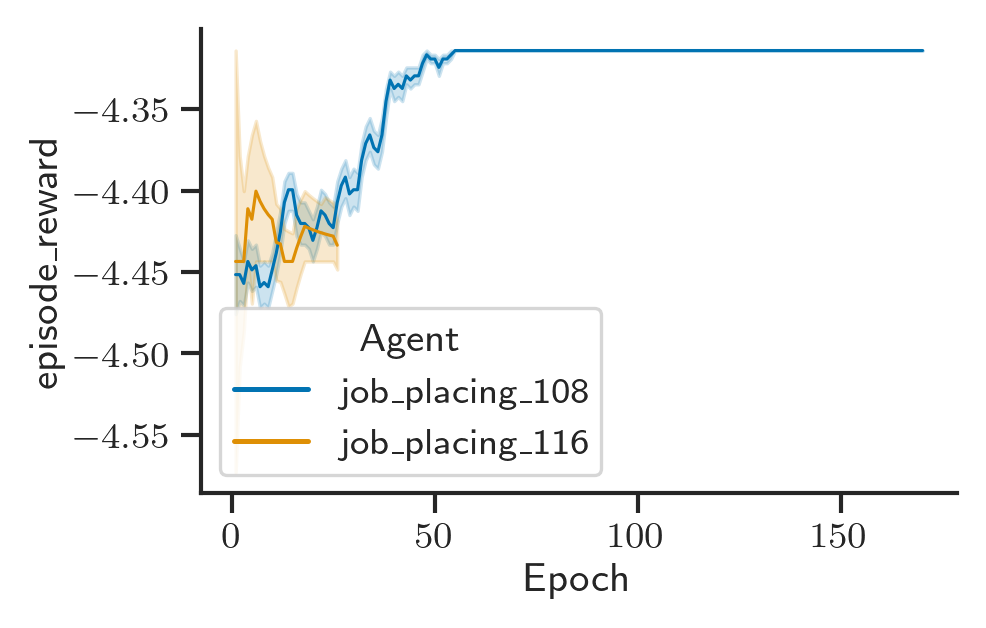

Plotting episode_lengths vs. Epoch...
Plotted episode_lengths vs. Epoch in 2.810 s.


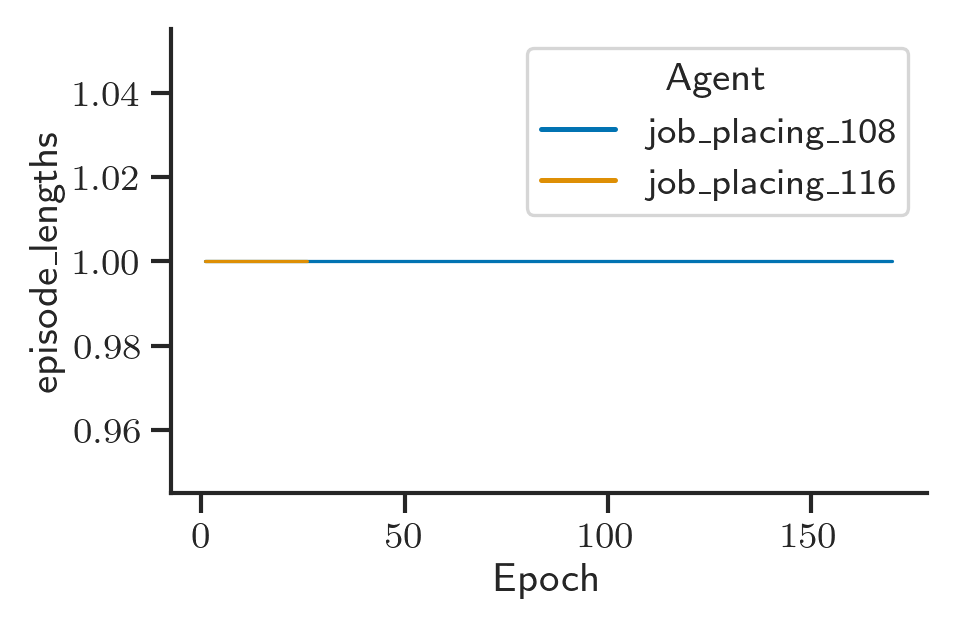

In [179]:
# RLLIB EPOCH ACTOR STATS WITH PER-STEP RESOLUTION
metrics_to_plot = {'episode_reward', 'episode_lengths'}
epochs_hist_stats = defaultdict(lambda: [])
if 'rllib_results' in results:
    for agent in results['rllib_results'].keys():
        hist_stats = results['rllib_results'][agent]['hist_stats']
        for idx, epoch_hist_stats in enumerate(hist_stats):
            for metric in metrics_to_plot:
                if metric not in {'normalised_episode_reward'}:
                    for step_metric in epoch_hist_stats[metric]:
                        epochs_hist_stats[metric].append(step_metric)
            epochs_hist_stats['Agent'].extend([agent for _ in range(len(epoch_hist_stats[metric]))])
            epochs_hist_stats['Epoch'].extend([results['rllib_results'][agent]['training_iteration'][idx] for _ in range(len(epoch_hist_stats[metric]))])
            
            
epochs_hist_stats_df = pd.DataFrame(epochs_hist_stats)
display(epochs_hist_stats_df)

scaling_factor = 1
x = 'Epoch'
hue = 'Agent'
for metric in metrics_to_plot:
    print(f'Plotting {metric} vs. {x}...')
    start_time = time.time()
    fig = plot_line(epochs_hist_stats_df, 
                    x=x, 
                    y=metric, 
                    hue=hue, 
                    xlabel=x, 
                    ylabel=metric, 
                    err_style='band', # 'band' 'bars'
                    ci=68, # 95 68
                    scaling_factor=scaling_factor,
                    show_fig=False)
    print(f'Plotted {metric} vs. {x} in {time.time() - start_time:.3f} s.')
    plt.show()

,cur_kl_coeff,cur_lr,total_loss,policy_loss,vf_loss,vf_explained_var,kl,entropy,entropy_coeff,Agent,Epoch
0,2.000000e-01,0.00005,19.847873,-0.001829,19.849702,-7.788340e-07,0.000002,0.693146,0.0,job_placing_108,1
1,1.000000e-01,0.00005,19.822549,-0.001721,19.824270,-9.139379e-07,0.000002,0.693137,0.0,job_placing_108,2
2,5.000000e-02,0.00005,19.941391,-0.001671,19.943061,-3.576279e-07,0.000002,0.693116,0.0,job_placing_108,3
3,2.500000e-02,0.00005,19.412338,-0.001755,19.414093,-5.086263e-07,0.000002,0.693080,0.0,job_placing_108,4
4,1.250000e-02,0.00005,19.958862,-0.001991,19.960853,-5.165736e-07,0.000003,0.693025,0.0,job_placing_108,5
...,...,...,...,...,...,...,...,...,...,...,...
191,9.536743e-08,0.00005,18.293331,-0.012502,18.305833,NaN,0.000104,0.678537,0.0,job_placing_116,22
192,4.768372e-08,0.00005,18.127379,-0.013588,18.140967,NaN,0.000122,0.673614,0.0,job_placing_116,23
193,2.384186e-08,0.00005,17.948222,-0.014770,17.962992,NaN,0.000143,0.667504,0.0,job_placing_116,24
194,1.192093e-08,0.00005,17.755163,-0.016053,17.771216,NaN,0.000167,0.659998,0.0,job_placing_116,25


Plotting total_loss vs. Epoch...
Plotted total_loss vs. Epoch in 0.040 s.


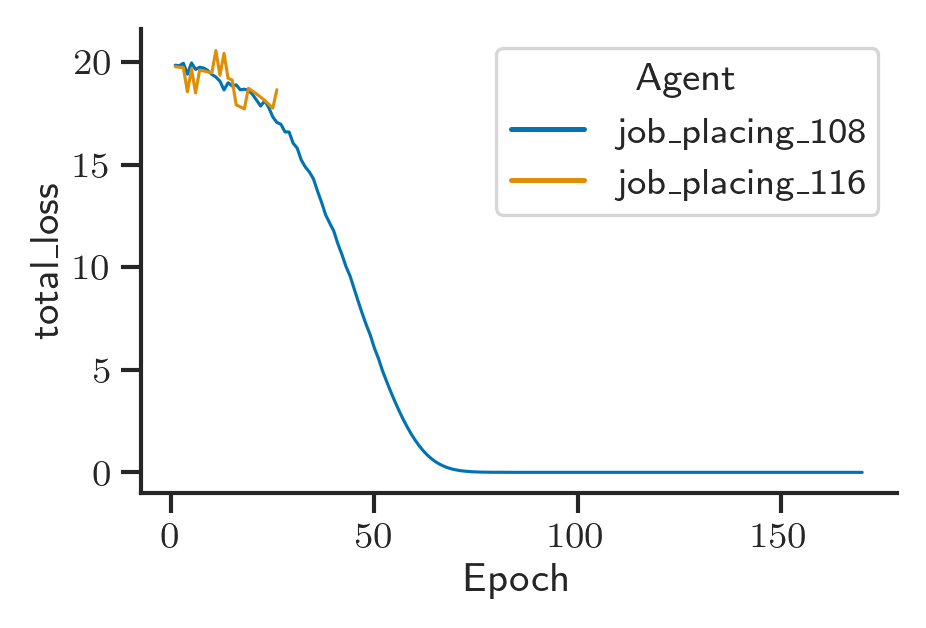

Plotting entropy_coeff vs. Epoch...
Plotted entropy_coeff vs. Epoch in 0.037 s.


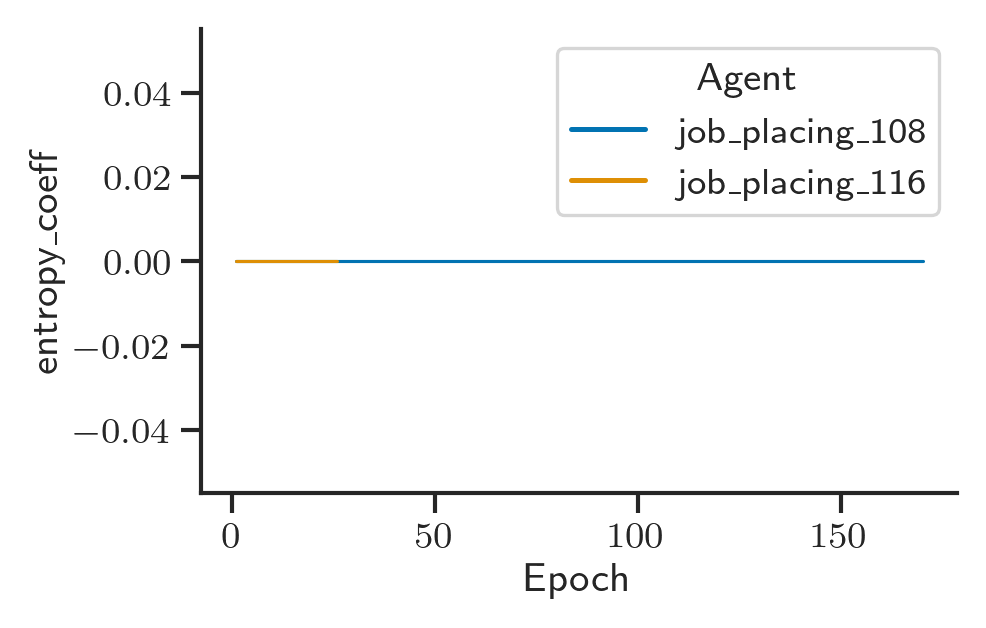

Plotting cur_lr vs. Epoch...
Plotted cur_lr vs. Epoch in 0.036 s.


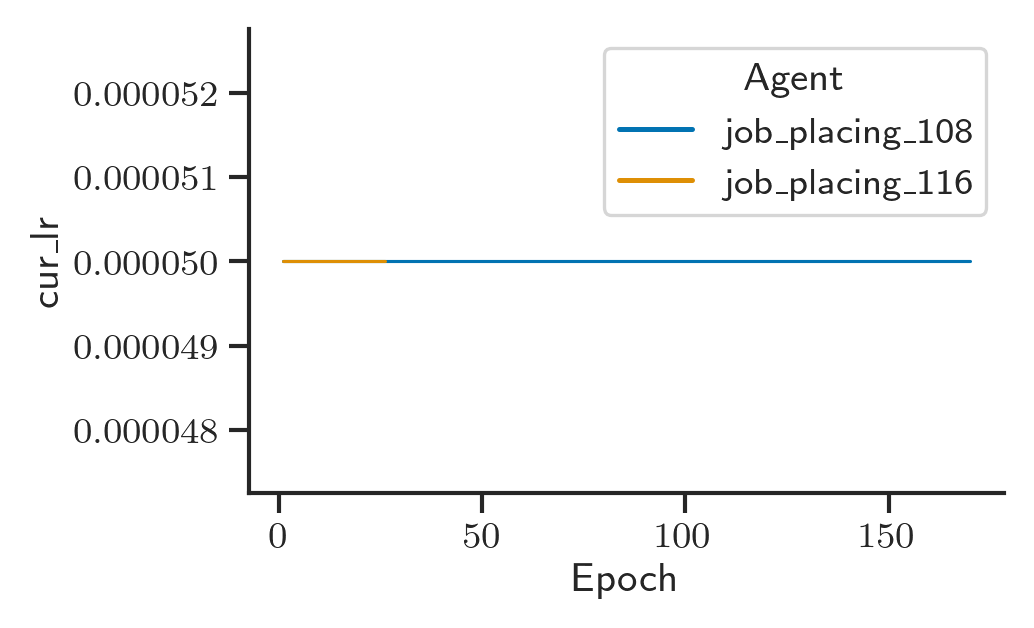

Plotting entropy vs. Epoch...
Plotted entropy vs. Epoch in 0.035 s.


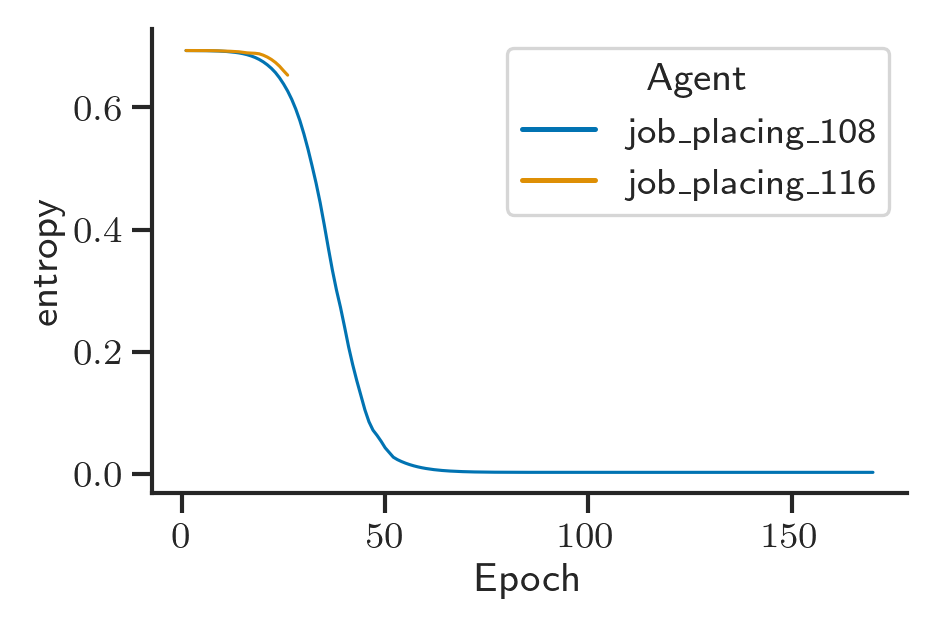

Plotting vf_explained_var vs. Epoch...
Plotted vf_explained_var vs. Epoch in 0.035 s.


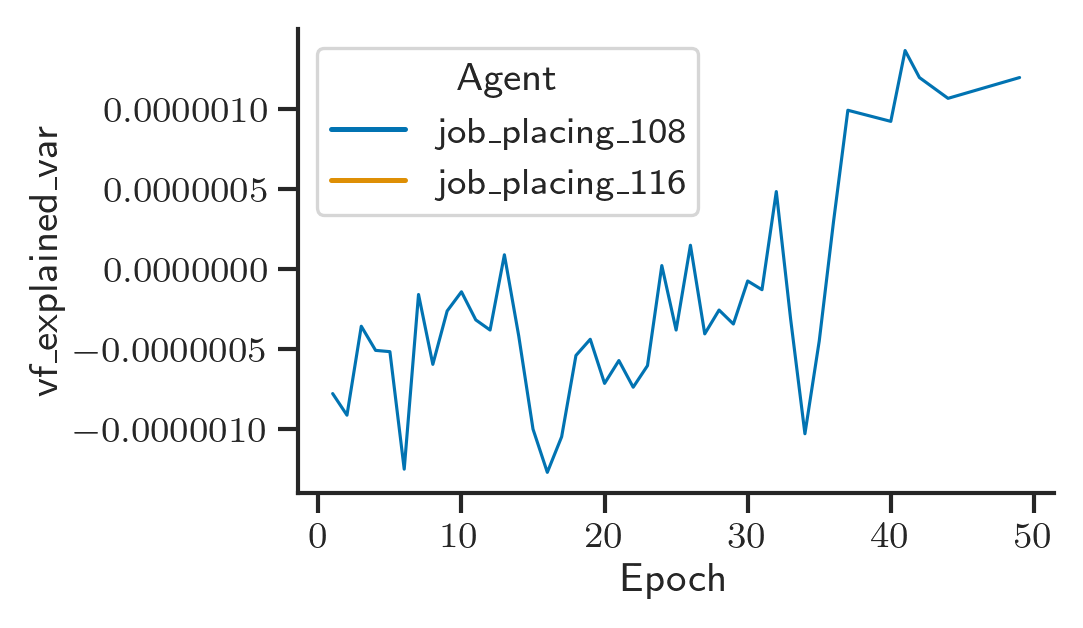

Plotting vf_loss vs. Epoch...
Plotted vf_loss vs. Epoch in 0.038 s.


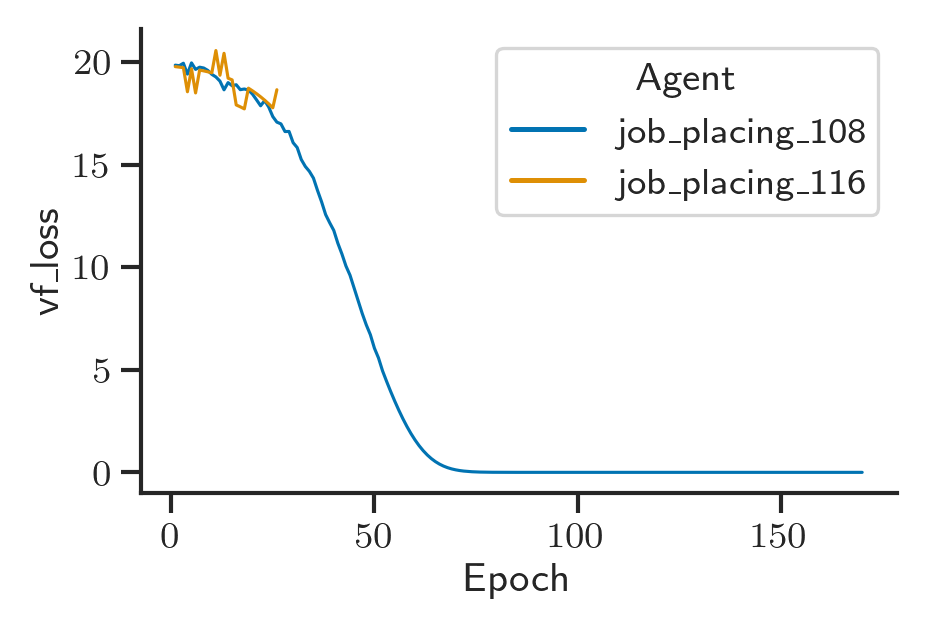

Plotting policy_loss vs. Epoch...
Plotted policy_loss vs. Epoch in 0.036 s.


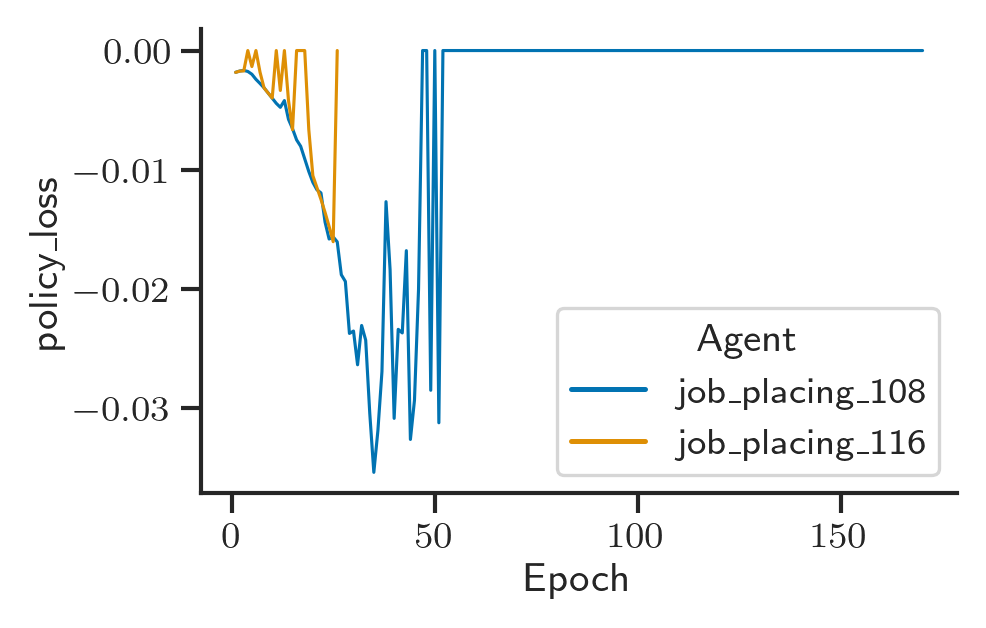

Plotting cur_kl_coeff vs. Epoch...
Plotted cur_kl_coeff vs. Epoch in 0.038 s.


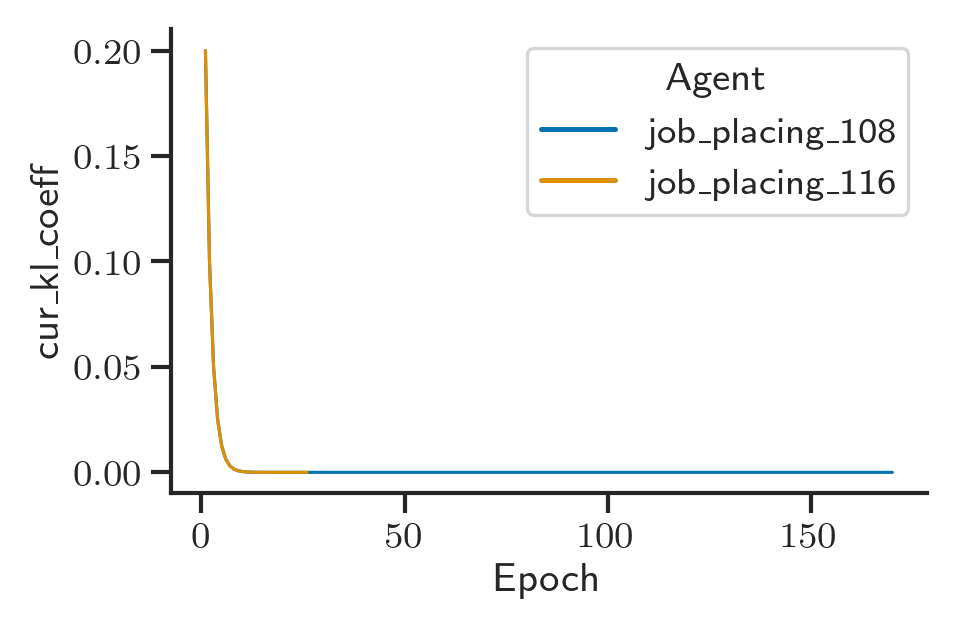

Plotting kl vs. Epoch...
Plotted kl vs. Epoch in 0.036 s.


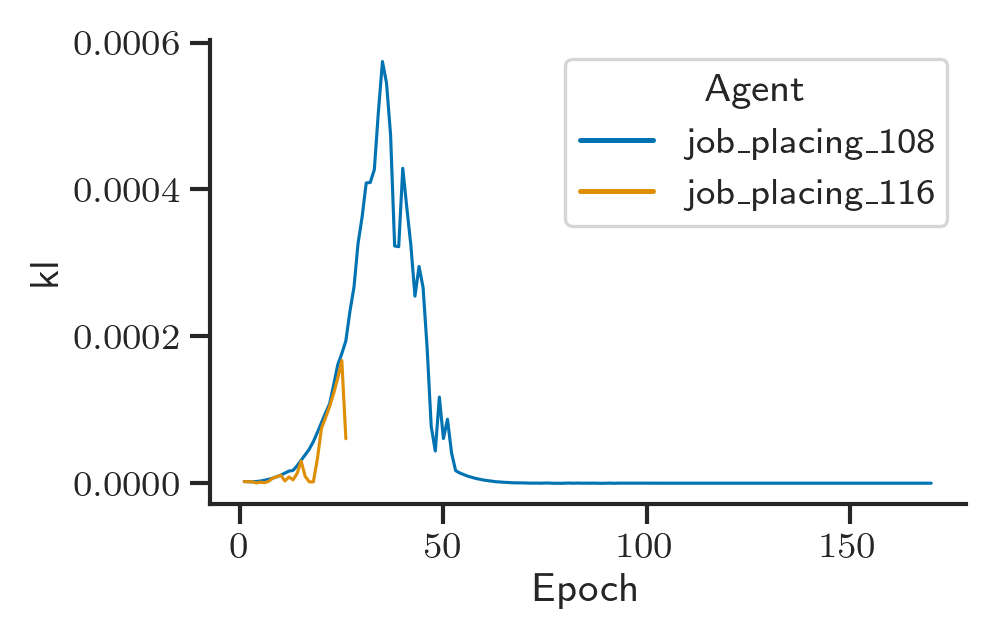

In [180]:
# RLLIB EPOCH LEARNER STATS
metrics_to_plot = set()
epochs_learner_stats = defaultdict(lambda: [])
if 'rllib_results' in results:
    for agent, training_stats in results['rllib_results'].items():
        epochs_stats['Epoch'].extend(training_stats['training_iteration'])
        epochs_stats['Agent'].extend([agent for _ in range(len(training_stats['training_iteration']))])
        
        info = results['rllib_results'][agent]['info']
        for idx, epoch_info in enumerate(info):
            for metric, stat in epoch_info['learner']['default_policy']['learner_stats'].items():
                metrics_to_plot.add(metric)
                epochs_learner_stats[metric].append(stat)
            epochs_learner_stats['Agent'].append(agent)
            epochs_learner_stats['Epoch'].append(results['rllib_results'][agent]['training_iteration'][idx])

            
epochs_learner_stats_df = pd.DataFrame(epochs_learner_stats)
display(epochs_learner_stats_df)

scaling_factor = 1
x = 'Epoch'
hue = 'Agent'
for metric in metrics_to_plot:
    print(f'Plotting {metric} vs. {x}...')
    start_time = time.time()
    fig = plot_line(epochs_learner_stats_df, 
                    x=x, 
                    y=metric, 
                    hue=hue, 
                    xlabel=x, 
                    ylabel=metric, 
                    err_style='band', # 'band' 'bars'
                    ci=68, # 95 68
                    scaling_factor=scaling_factor,
                    show_fig=False)
    print(f'Plotted {metric} vs. {x} in {time.time() - start_time:.3f} s.')
    plt.show()